In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}


In [2]:
gwas = pd.read_csv('gwas_catalog_v1.0.2-associations_e113_r2025-03-08.tsv', sep='\t')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/4109629132.py:1: DtypeWarning: Columns (9,11,12,13,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  gwas = pd.read_csv('gwas_catalog_v1.0.2-associations_e113_r2025-03-08.tsv', sep='\t')


In [3]:
# Clean up MAPPED_GENE column
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split(',').str[0]
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split('-').str[0]

In [4]:
gwas[['REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID',]]

,REPORTED GENE(S),MAPPED_GENE,UPSTREAM_GENE_ID,DOWNSTREAM_GENE_ID
0,"SEPT5, GP1BB",GP1BB,NaN,NaN
1,ARVCF,ARVCF,NaN,NaN
2,MN1,MN1,NaN,NaN
3,EWSR1,EWSR1,NaN,NaN
4,TMPRSS6,NaN,NaN,NaN
...,...,...,...,...
788647,NaN,FADS2,NaN,NaN
788648,NaN,FADS2,NaN,NaN
788649,NaN,FADS2,NaN,NaN
788650,NaN,FADS2,NaN,NaN


<Axes: >

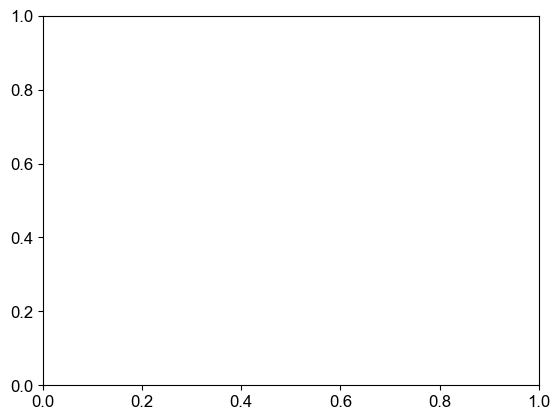

In [5]:
# Manhattan plot from gwas data for diabetes

sns.scatterplot()

In [6]:
# Select genes based on patways modeled in the minimal - whole body model
# https://www.gsea-msigdb.org/gsea/msigdb/human/genesets.jsp?collection=CP:REACTOME

gene_sets_pathways = pd.read_csv('gene_sets_curated_reactome_v2.csv')
# Drop all the are annoteted use == False 
gene_sets_pathways = gene_sets_pathways[gene_sets_pathways.use == True]


In [7]:
gene_sets_pathways

,gene_name,pathway,use,comment
1,ALDOA,Glucose catabolism,True,NaN
2,ALDOB,Glucose catabolism,True,NaN
3,ALDOC,Glucose catabolism,True,NaN
4,BPGM,Glucose catabolism,True,NaN
5,ENO1,Glucose catabolism,True,NaN
...,...,...,...,...
248,PRKACA,Triglyceride catabolism,True,NaN
249,PRKACB,Triglyceride catabolism,True,NaN
250,PRKACG,Triglyceride catabolism,True,NaN
251,PNPLA2,Triglyceride catabolism,True,DW added (ATGL)


In [8]:
# Map the GWAS catalog to the model
gwas_mapped = pd.merge(gwas, gene_sets_pathways, left_on='MAPPED_GENE', right_on='gene_name', how='left')
gwas_mapped = gwas_mapped[gwas_mapped['gene_name'].notnull()]

In [9]:
# Parse the initial smaple size field into number and ethinicity
import re
gwas_mapped['SAMPLE_SIZE'] = gwas_mapped['INITIAL SAMPLE SIZE'].apply(lambda entry: sum([int(i) for i in re.findall(r'\d+', entry.replace(',',''))]) if type(entry) == str  else np.nan)


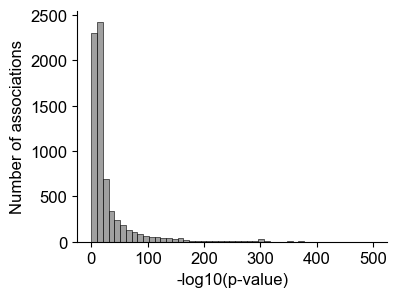

In [10]:
# Plot p-value distribution
f, ax = plt.subplots(figsize=(4, 3))
sns.histplot(gwas_mapped['PVALUE_MLOG'], bins=np.linspace(0, 500, 50), color='grey')

ax.set_xlabel('-log10(p-value)')
ax.set_ylabel('Number of associations')
sns.despine()


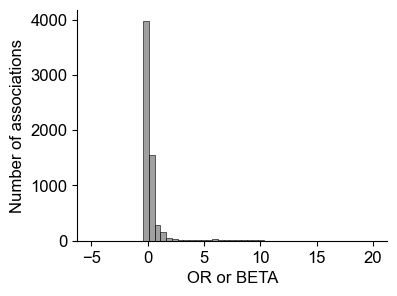

In [11]:
# Histogram of traits asooicated with reactions in the model
f, ax = plt.subplots(figsize=(4, 3))
sns.histplot(gwas_mapped['OR or BETA'], color='grey', bins=np.linspace(-5, 20, 50))
ax.set_ylabel('Number of associations')
ax.set_xlabel('OR or BETA')
sns.despine()

In [12]:
# Write the list of mapped traits into a file
gwas_mapped.to_csv('gwas_mapped.csv')

In [13]:
gwas_mapped.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV',
       'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'STUDY ACCESSION',
       'GENOTYPING TECHNOLOGY', 'gene_name', 'pathway', 'use', 'comment',
       'SAMPLE_SIZE'],
      dtype='object')

In [14]:
# Make pivot table of the mapped traits and the reactions
# Try again using mapped trait 
column = 'MAPPED_TRAIT'
gwas_mapped_pivot = gwas_mapped.pivot_table(index='gene_name', columns=column, values='OR or BETA')

Text(0, 0.5, 'Number of traits')

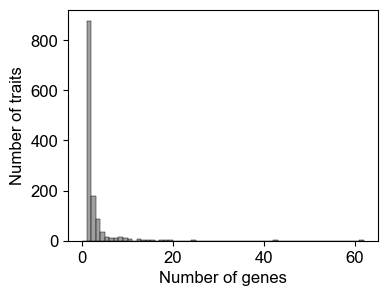

In [15]:
gwas_mapped_pivot.shape

num_genes_per_trait =gwas_mapped_pivot.shape[0] - gwas_mapped_pivot.isna().sum(axis=0).sort_values(ascending=True)

max_counts = num_genes_per_trait.max()

f, ax = plt.subplots(figsize=(4, 3))

sns.histplot(num_genes_per_trait, bins=np.linspace(0, max_counts, max_counts+1), color='grey')

ax.set_xlabel('Number of genes')
ax.set_ylabel('Number of traits')

In [16]:
trait_list = [ t for t in gwas_mapped['MAPPED_TRAIT'].unique()] # if 'diabetes' in str(t).lower() ]


# Write into a file
with open('mapped_trait_list.txt', 'w') as f:
    for item in trait_list:
        f.write("%s\n" % item)



In [17]:
gwas_mapped['MAPPED_TRAIT'].unique()

array(['hematocrit', 'eosinophil count',
       'self reported educational attainment', ..., 'uterine prolapse',
       'Varicose veins', 'X-13431--nonanoylcarnitine measurement'],
      dtype=object)

In [18]:
# Common parameters to plot 
order = [
    'Insulin secretion',
    'Insulin receptor signaling', 
    'Glucose catabolism',
    'Lactate metabolism',
    'Fatty acid oxidation', 
    'Ketone metabolism',
    'Triglyceride biosynthesis',
    'Triglyceride catabolism',
    'Glycogen breakdown',
]

N = 75000

In [19]:
hue_order = gwas_mapped.pathway.unique()    

In [20]:
summary_aggregated = dict()

In [21]:
gwas_mapped.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV',
       'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'STUDY ACCESSION',
       'GENOTYPING TECHNOLOGY', 'gene_name', 'pathway', 'use', 'comment',
       'SAMPLE_SIZE'],
      dtype='object')

In [22]:
# Mapp traits to understandbale traits
MAPPING = {
    'Glucose': ['glucose measurement', 'BMI-adjusted fasting blood glucose measurement'],
    'Insulin': ['blood insulin amount', 'insulin measurement', 'BMI-adjusted fasting blood insulin measurement',
                 'Headache, blood insulin amount',],
    'Lactate': ['lactate measurement', ],
    'Fatty acid': ['fatty acid measurement', 'polyunsaturated fatty acid measurement','saturated fatty acids measurement '],
    'Ketones': ['Ketonuria', 'acetoacetate measurement','3-hydroxybutyrate measurement'],
    'Type 2 diabetes': ['type 2 diabetes mellitus',]
}


In [23]:
# BMI-adjusted fasting blood glucose measurement

# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['glucose measurement', 'BMI-adjusted fasting blood glucose measurement']

# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k 
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]

# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Glucose'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_Glucose.csv')

# Summary table: 
summary_aggregated['Glucose'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()


,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT
pathway,,,,,,,,,
Glucose catabolism,2,2,3,3,3,3,3,3,1
Insulin receptor signaling,2,5,5,5,5,5,7,7,1
Insulin secretion,4,23,11,11,11,11,50,21,1
Ketone metabolism,1,2,2,2,2,2,1,2,1
Triglyceride biosynthesis,1,1,2,2,2,2,3,3,1


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/1801876865.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


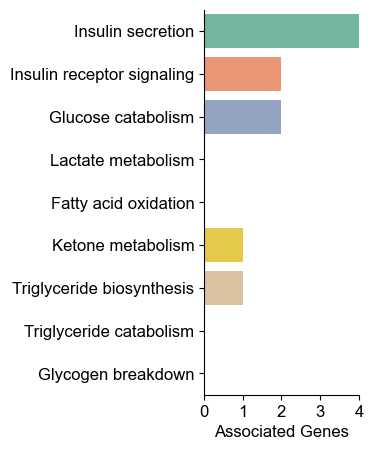

In [24]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()

sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)

max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 


sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

plt.savefig("output/gwas_glucose.svg", bbox_inches='tight')

In [25]:
# Insulin 
# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['blood insulin amount', 'insulin measurement', 'BMI-adjusted fasting blood insulin measurement',
                 'Headache, blood insulin amount',]

# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k 
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]

# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Insulin'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_Insulin.csv')


# Summary table: 
summary_aggregated['Insulin'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()


,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT
pathway,,,,,,,,,
Insulin receptor signaling,1,2,2,2,2,2,2,2,1
Insulin secretion,1,2,3,3,3,3,3,3,1


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/2016017428.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


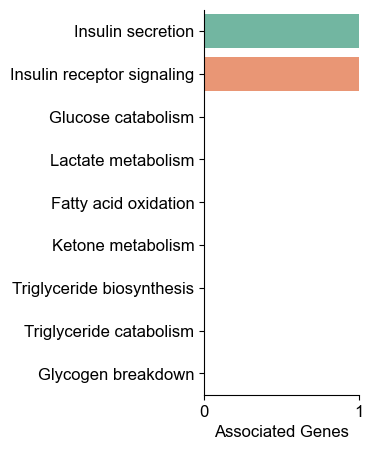

In [26]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()


sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)

sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 


plt.savefig("output/gwas_insulin.svg", bbox_inches='tight')

In [27]:
# Lactate 
# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['lactate measurement', ]
# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k 
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]


# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Lactate'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_lactate.csv')



# Summary table: 
summary_aggregated['Lactate'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()


,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT
pathway,,,,,,,,,
Glucose catabolism,2,5,3,3,3,3,5,3,1
Insulin secretion,1,1,3,3,3,3,3,3,1


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/2664648713.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


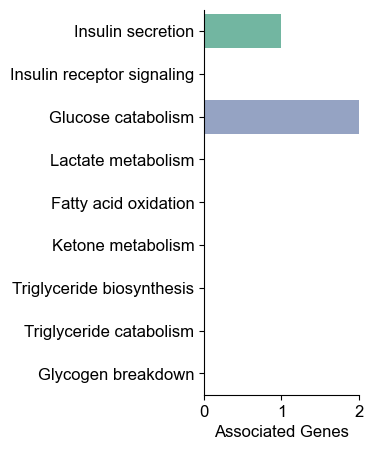

In [28]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()


sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)

max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 


sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

plt.savefig("output/gwas_lactate.svg", bbox_inches='tight')

In [29]:
# Fatty acids  
# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['fatty acid measurement', 'polyunsaturated fatty acid measurement','saturated fatty acids measurement ']
# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k 
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]

# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Fatty acids'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_fatty_acids.csv')



# Summary table: 
summary_aggregated['Fatty acids'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()

,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT
pathway,,,,,,,,,
Fatty acid oxidation,1,1,2,2,2,2,10,2,1
Insulin receptor signaling,2,2,1,1,1,1,3,1,1
Insulin secretion,2,2,3,3,3,3,26,4,1
Triglyceride biosynthesis,2,3,1,1,1,1,4,1,1


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/4112546698.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


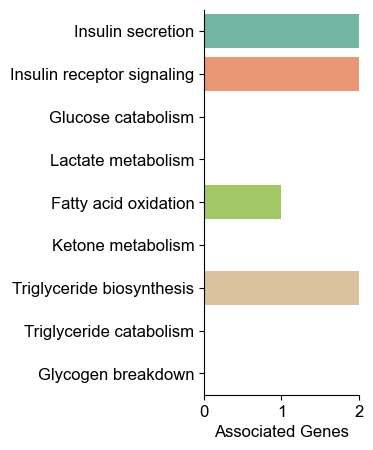

In [30]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()


sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)

max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 

sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

plt.savefig("output/gwas_fatty_acids.svg", bbox_inches='tight')

In [31]:
# Ketones 
# Ketonuria

# Lactate 
# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['Ketonuria', 'acetoacetate measurement','3-hydroxybutyrate measurement']
# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k 
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]

# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE','OR or BETA'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Ketones'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_Ketones.csv')


# Summary table: 
summary_aggregated['Ketones'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()

,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,OR or BETA,MAPPED_TRAIT
pathway,,,,,,,,,,
Glucose catabolism,1,1,2,2,2,2,2,2,2,1
Ketone metabolism,1,2,3,3,3,3,4,4,4,1
Lactate metabolism,1,1,1,1,1,1,1,1,1,1
Triglyceride biosynthesis,1,4,3,3,3,3,4,4,4,1


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/2733152349.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


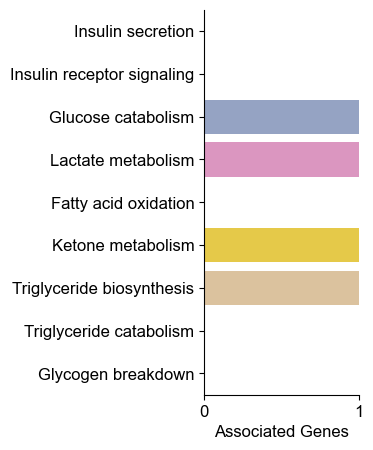

In [32]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()


sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)

max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 

sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

plt.savefig("output/gwas_ketones.svg", bbox_inches='tight')

In [33]:
# Diabetes 

# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['type 2 diabetes mellitus',]
# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k 
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]

# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Type 2 diabetes'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_diabetes.csv')

# Summary table: 
summary_aggregated['Diabetes'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()


,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT
pathway,,,,,,,,,
Glucose catabolism,2,2,4,4,4,4,4,4,1
Glycogen breakdown,1,3,4,4,4,4,5,5,1
Insulin receptor signaling,5,13,7,7,6,7,12,8,1
Insulin secretion,5,21,15,15,11,15,55,23,1
Lactate metabolism,2,3,2,2,2,2,4,3,1
Triglyceride biosynthesis,1,2,3,3,3,3,4,4,1


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/2634262046.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


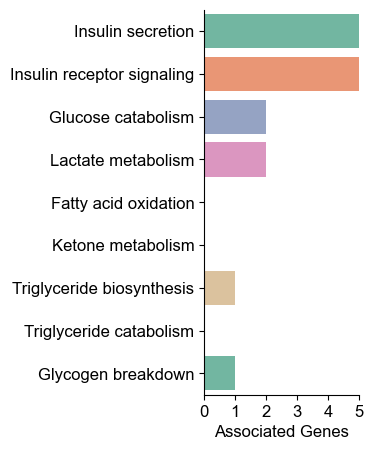

In [34]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()


sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)
max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 

sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

plt.savefig("output/gwas_diabetes.svg", bbox_inches='tight')

In [35]:
# Diabetes 

# Make plot for the main text 
# combine a list of traits: 
mapped_traits = ['metabolic syndrome',]
# aggregate results 
gwas_mapped_selected = []
for trait in mapped_traits:
    glucose_measurement_genes = gwas_mapped_pivot[trait].dropna()
    selected_genes = gwas_mapped.gene_name.isin(glucose_measurement_genes.index) & (gwas_mapped['MAPPED_TRAIT'] == trait)
    this_gwas_mapped_selected = gwas_mapped[selected_genes]
    gwas_mapped_selected.append(this_gwas_mapped_selected)

gwas_mapped_selected = pd.concat(gwas_mapped_selected, axis=0)


# Check p-value < 5 x 10^-8 and sample size > 100k ()
quality_check = (gwas_mapped_selected['P-VALUE'] < 5e-8) & (gwas_mapped_selected['SAMPLE_SIZE'] > N) 
gwas_mapped_selected = gwas_mapped_selected[quality_check]

# Group to filterour duplicated reports  
gwas_mapped_grouped = gwas_mapped_selected.groupby(['pathway','gene_name', 'SNPS','PUBMEDID','STUDY','FIRST AUTHOR','DATE','P-VALUE','SAMPLE_SIZE'])['MAPPED_TRAIT'].nunique().reset_index()
gwas_mapped_grouped['MAPPED_TRAIT'] = 'Metabolic syndrome'

# Write a table 
gwas_mapped_grouped.to_csv('./output/MAPPED_SNPS_metabolic_syndrome.csv')
# Summary table: 
summary_aggregated['Metabolic syndrome'] = gwas_mapped_grouped.groupby('pathway').nunique()
gwas_mapped_grouped.groupby('pathway').nunique()


,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT
pathway,,,,,,,,,
Insulin receptor signaling,2,4,1,1,1,1,4,1,1
Insulin secretion,5,13,3,3,3,3,14,3,1
Lactate metabolism,1,1,1,1,1,1,1,1,1
Triglyceride biosynthesis,1,1,1,1,1,1,1,1,1
Triglyceride catabolism,1,1,1,1,1,1,1,1,1


In [36]:
summary_aggregated.keys()

dict_keys(['Glucose', 'Insulin', 'Lactate', 'Fatty acids', 'Ketones', 'Diabetes', 'Metabolic syndrome'])

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/690076402.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax,


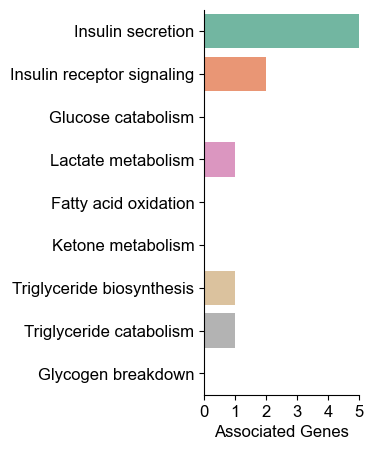

In [37]:
# Plot the summary
fig, ax = plt.subplots(1, 1, figsize=(2, 5),)

summary = gwas_mapped_grouped.groupby('pathway').nunique()


sns.barplot(data=summary, y="pathway" ,x='gene_name', ax=ax, 
            palette='Set2', legend=False, order=order)

max_genes = max(summary['gene_name'])
plt.xlim([0,max_genes])
plt.xticks(range(max_genes+1),range(max_genes+1)) 

sns.despine()
ax.set_xlabel("Associated Genes")
ax.set_ylabel("")

plt.savefig("output/gwas_metabolic_syndrome.svg", bbox_inches='tight')


In [38]:
# Make an aggregated dataframe 
results = []
for k, d in summary_aggregated.items():
    f = d.reset_index()
    f['MAPPED_TRAIT'] = k
    results.append(f)    

results = pd.concat(results)

results.to_csv('./output/summary_of_genes.csv')

In [39]:
results['M_LOG10_P'] =  -1 * np.log10(results['P-VALUE'])

In [40]:
results

,pathway,gene_name,SNPS,PUBMEDID,STUDY,FIRST AUTHOR,DATE,P-VALUE,SAMPLE_SIZE,MAPPED_TRAIT,OR or BETA,M_LOG10_P
0,Glucose catabolism,2,2,3,3,3,3,3,3,Glucose,NaN,-0.477121
1,Insulin receptor signaling,2,5,5,5,5,5,7,7,Glucose,NaN,-0.845098
2,Insulin secretion,4,23,11,11,11,11,50,21,Glucose,NaN,-1.698970
3,Ketone metabolism,1,2,2,2,2,2,1,2,Glucose,NaN,-0.000000
4,Triglyceride biosynthesis,1,1,2,2,2,2,3,3,Glucose,NaN,-0.477121
0,Insulin receptor signaling,1,2,2,2,2,2,2,2,Insulin,NaN,-0.301030
1,Insulin secretion,1,2,3,3,3,3,3,3,Insulin,NaN,-0.477121
0,Glucose catabolism,2,5,3,3,3,3,5,3,Lactate,NaN,-0.698970
1,Insulin secretion,1,1,3,3,3,3,3,3,Lactate,NaN,-0.477121
0,Fatty acid oxidation,1,1,2,2,2,2,10,2,Fatty acids,NaN,-1.000000


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/3834590620.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='gene_name', ax=ax,  palette=colors_met,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/3834590620.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='gene_name', ax=ax,  palette=colors_met,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_96626/3834590620.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset,

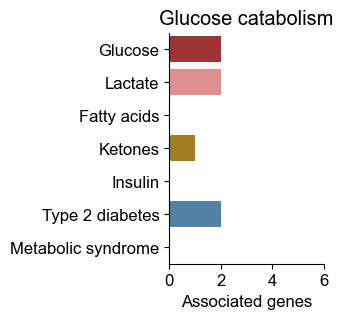

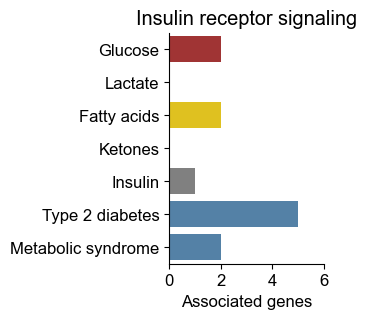

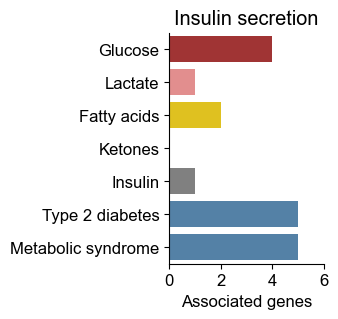

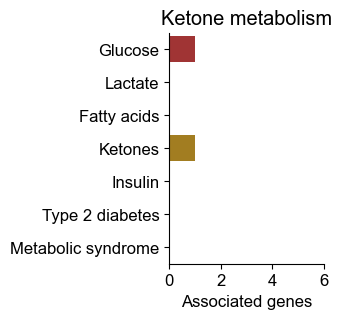

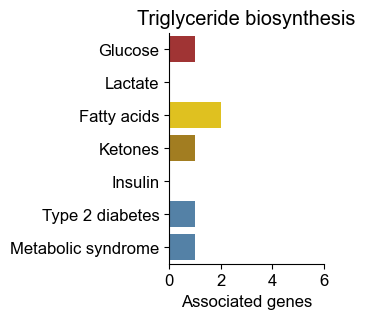

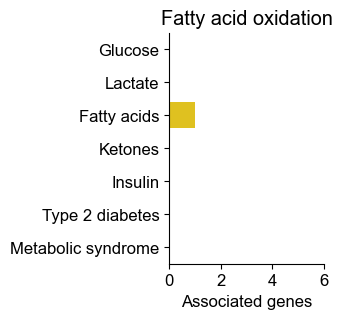

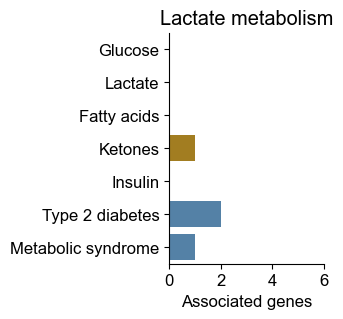

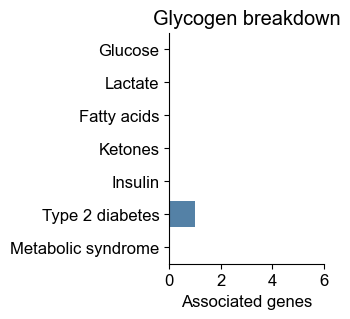

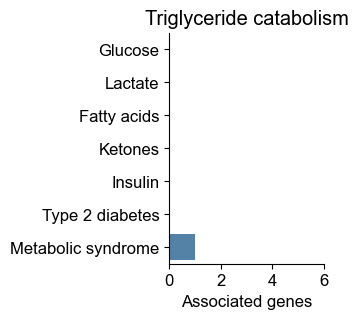

In [41]:

order = ['Glucose', 'Lactate','Fatty acids','Ketones','Insulin', 'Type 2 diabetes', 'Metabolic syndrome']

map = {'Glucose':'Glucose', 
       'Lactate':"Lactate",
       'Fatty acids':'Fatty acids',
       'Ketones':'Ketones',
       'Insulin':'Insulin', 
       'Diabetes':"Type 2 diabetes",
       'Metabolic syndrome':'Metabolic syndrome',}

colors_met = ['firebrick', 'lightcoral',  'gold' ,'darkgoldenrod', 'grey' , 'steelblue','steelblue']


# Make plot for each pathway:
for p in results.pathway.unique():
    subset = results[(results.pathway == p)  ].reset_index()

    fig, ax = plt.subplots(1, 1, figsize=(2, 3),)

    subset.MAPPED_TRAIT = subset.MAPPED_TRAIT.map(map)

    sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='gene_name', ax=ax,  palette=colors_met,
                legend=False, order=order, err_kws={'color': 'black','linewidth': 1.5},)

    # Title
    plt.title(p)

    plt.xlim(0,6)

    sns.despine()
    ax.set_xlabel("Associated genes")
    ax.set_ylabel("")

    plt.savefig(f"output/trait_effects_{p}.svg", bbox_inches='tight')




In [42]:
# Make joint dataframe from all ascocciations: 
# Get all csv files from output 
import os 
import pandas as pd 

data = []
for file_name in os.listdir('./output'):
    if file_name.endswith('.csv'):
        if not "summary" in file_name:
            df = pd.read_csv('./output/'+file_name, index_col=0)
            data.append(df)

data = pd.concat(data)

# quality_check = (data['P-VALUE'] < 5e-8) & (data['SAMPLE_SIZE'] > N) 
# data = data[quality_check]


In [43]:
publications = data.groupby(['PUBMEDID','STUDY','FIRST AUTHOR','DATE'])['gene_name'].count()
publications = publications.reset_index()
publications.sort_values(by='gene_name', ascending=False, inplace=True)

publications

,PUBMEDID,STUDY,FIRST AUTHOR,DATE,gene_name
19,35213538,Characterising metabolomic signatures of lipid...,Richardson TG,2022-02-25,37
27,39024449,Diversity and scale: Genetic architecture of 2...,Verma A,2024-07-19,29
25,38374256,Genetic drivers of heterogeneity in type 2 dia...,Suzuki K,2024-02-19,21
26,38448586,Genome-wide characterization of circulating me...,Karjalainen MK,2024-03-06,20
13,32541925,Discovery of 318 new risk loci for type 2 diab...,Vujkovic M,2020-06-15,16
23,37679419,"GWAS of random glucose in 476,326 individuals ...",Lagou V,2023-09-07,14
18,34594039,A cross-population atlas of genetic associatio...,Sakaue S,2021-09-30,13
29,39349817,Multivariate genomic analysis of 5 million peo...,Park S,2024-09-30,12
21,36764567,Metabolomic Investigation of Major Depressive ...,Davyson E,2023-02-09,12
15,33462484,Genetics of 35 blood and urine biomarkers in t...,Sinnott-Armstrong N,2021-01-18,10


In [44]:
pathways = ['Insulin receptor signaling', 'Insulin secretion',
        'Glucose catabolism', 'Lactate metabolism',
       'Fatty acid oxidation','Ketone metabolism', 'Triglyceride biosynthesis', 
       'Triglyceride catabolism', 'Glycogen breakdown']

MAPPED_TRAITS = [ 'Glucose',  'Lactate', 'Fatty acids', 'Ketones', 'Insulin','Type 2 diabetes' , 'Metabolic syndrome']


In [45]:
# Make stes for each Mapped TRAIT
len(data.gene_name.unique())

data.gene_name.unique()

array(['GRB10', 'GCKR', 'INSR', 'PIK3C3', 'EXOC4', 'EXOC6', 'GCK',
       'SLC30A8', 'PCK1', 'GPAM', 'FABP2', 'PFKP', 'SLC2A1', 'PDE3B',
       'INS', 'AACS', 'DGAT1', 'ENO3', 'HK1', 'PGM1', 'GAB2', 'IRS2',
       'ERO1B', 'LDHB', 'PKLR', 'PFKFB2', 'CPT1A', 'KLB', 'PIK3R1',
       'DGAT2', 'SLC2A4', 'OXCT1', 'MPC1'], dtype=object)

In [46]:
len(data.SNPS.unique())

102

In [47]:
# Map associated genes to pathways 
from pandas.api.types import CategoricalDtype

gene_sets_pathways.index = gene_sets_pathways.gene_name
gene_sets_associated = gene_sets_pathways.loc[data.gene_name.unique()]

gene_sets_associated['pathway'] = gene_sets_associated['pathway'].astype(CategoricalDtype(categories=pathways, ordered=True))

gene_sets_associated = gene_sets_associated.sort_values(by='pathway')

gene_sets_associated

,gene_name,pathway,use,comment
gene_name,,,,
GRB10,GRB10,Insulin receptor signaling,True,NaN
GAB2,GAB2,Insulin receptor signaling,True,NaN
INSR,INSR,Insulin receptor signaling,True,NaN
PIK3C3,PIK3C3,Insulin receptor signaling,True,NaN
PDE3B,PDE3B,Insulin receptor signaling,True,NaN
IRS2,IRS2,Insulin receptor signaling,True,NaN
KLB,KLB,Insulin receptor signaling,True,NaN
PIK3R1,PIK3R1,Insulin receptor signaling,True,NaN
INS,INS,Insulin secretion,True,DW revised


In [48]:
gene_sets_associated = gene_sets_associated.index
gene_sets_associated

Index(['GRB10', 'GAB2', 'INSR', 'PIK3C3', 'PDE3B', 'IRS2', 'KLB', 'PIK3R1',
       'INS', 'ERO1B', 'SLC30A8', 'GCK', 'EXOC6', 'EXOC4', 'GCKR', 'SLC2A1',
       'PFKFB2', 'ENO3', 'HK1', 'SLC2A4', 'PFKP', 'PKLR', 'LDHB', 'MPC1',
       'PCK1', 'CPT1A', 'OXCT1', 'AACS', 'GPAM', 'DGAT2', 'DGAT1', 'FABP2',
       'PGM1'],
      dtype='object', name='gene_name')

In [49]:
from upsetplot import UpSet, from_contents

# For each trait make a set: 
associated_genes_per_trait = data.groupby('MAPPED_TRAIT')['gene_name'].unique()

upset_data = from_contents(associated_genes_per_trait)

In [50]:
set_table = upset_data.reset_index()

In [51]:
set_table

,Fatty acids,Glucose,Insulin,Ketones,Lactate,Metabolic syndrome,Type 2 diabetes,id
0,True,False,False,False,False,False,False,CPT1A
1,True,False,False,False,False,False,False,KLB
2,True,False,False,False,False,False,False,PIK3R1
3,True,False,False,False,False,True,False,EXOC6
4,True,True,True,False,True,True,True,GCKR
5,True,False,False,False,False,False,False,DGAT2
6,True,False,False,True,False,True,False,GPAM
7,False,True,False,False,True,False,False,PFKP
8,False,True,False,False,False,False,False,SLC2A1
9,False,True,True,False,False,False,True,GRB10


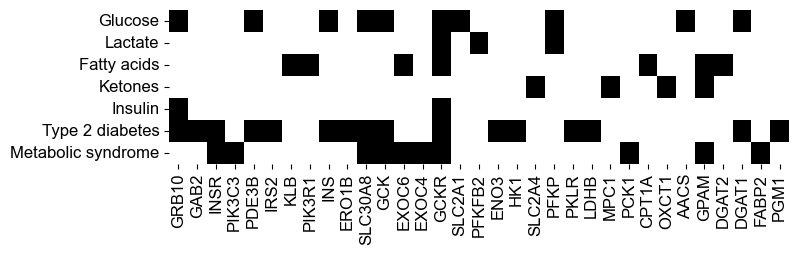

In [52]:
from matplotlib import cm

table_genes_trait = set_table.copy()
table_genes_trait.index = table_genes_trait.id
table_genes_trait = table_genes_trait.drop(columns='id')

table_genes_trait

f,ax = plt.subplots(1,1, figsize=(8,2))

sns.heatmap(table_genes_trait.loc[gene_sets_associated,MAPPED_TRAITS].T, cmap = cm.binary, cbar=False, ax=ax)

plt.xlabel('')

plt.savefig(f"output/genes_associated_per_trait.svg", bbox_inches='tight')


In [53]:
# Make joint dataframe from all ascocciations: 
# Get all csv files from output 
import os 
import pandas as pd 

data = []
for file_name in os.listdir('./summary'):
    if file_name.endswith('.csv'):
        if not "summary" in file_name:
            df = pd.read_csv('./output/'+file_name, index_col=0)
            data.append(df)

data = pd.concat(data)

# quality_check = (data['P-VALUE'] < 5e-8) & (data['SAMPLE_SIZE'] > N) 
# data = data[quality_check]


NameError: name 'N_SNSPS_GENE_TRAIT' is not defined

Text(0.5, -8.277777777777782, '')

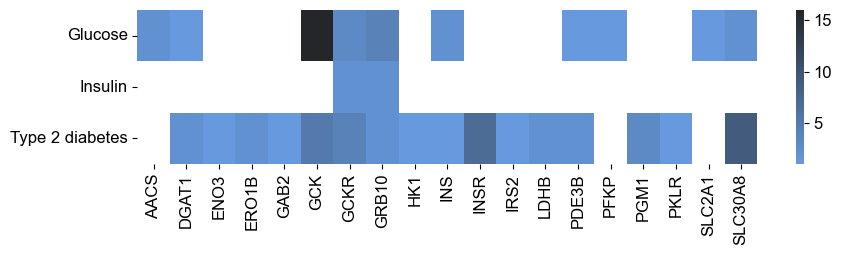

In [56]:
N_SNSPS_GENE_TRAIT = data.groupby(['MAPPED_TRAIT','gene_name' ])['SNPS'].nunique().reset_index()
N_SNSPS_GENE_TRAIT = N_SNSPS_GENE_TRAIT.pivot(index='MAPPED_TRAIT', columns='gene_name').rename_axis(None)
N_SNSPS_GENE_TRAIT.columns = N_SNSPS_GENE_TRAIT.columns.droplevel(0)


f,ax = plt.subplots(1,1, figsize=(10,2))

cm = sns.dark_palette("#69d", reverse=True, as_cmap=True)

sns.heatmap(N_SNSPS_GENE_TRAIT.loc[:,:], cmap=cm, ax=ax)

plt.xlabel('')

#plt.savefig(f"output/genes_associated_per_trait.svg", bbox_inches='tight')


In [ ]:
MAPPED_TRAITS

['Glucose',
 'Lactate',
 'Fatty acids',
 'Ketones',
 'Insulin',
 'Type 2 diabetes',
 'Metabolic syndrome']